# Analysis of results

In [294]:
# -- Libraries and defaults

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from functools import reduce
from matplotlib.lines import Line2D

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.precision", 4)
pd.set_option("styler.format.precision", 4)

COLORS = plt.get_cmap("tab10")
BLUE, ORANGE, RED = "tab:blue", "tab:orange", "tab:red"

In [295]:
# -- Global configuration

DIR_EXPERIMENTS = "results/scores/linear/uniform/"
SAVE_FIG = False  # Save format is .pdf
SAVE_FIG_LATEX_PREAMBLE = "Preprint"  # Bayesian or Preprint
DIR_SAVE = "results/figures/linear/uniform/"
FONT_SIZE_LATEX = 15  # Font size for saved figures

In [296]:
# -- Set matplotlib parameters

plt.rc("axes", prop_cycle=plt.cycler("color", COLORS.colors))
legend_fontsize = FONT_SIZE_LATEX - 2 if SAVE_FIG else None

if SAVE_FIG:  # Mirror the style of a specific LaTeX document
    if SAVE_FIG_LATEX_PREAMBLE == "Preprint":
        plt.rcParams.update(
            {
                "font.family": "serif",
                "font.size": FONT_SIZE_LATEX,
                "axes.linewidth": 0.75,
                "text.usetex": True,
                "pgf.rcfonts": False,
                "pgf.texsystem": "pdflatex",  # default is xetex
                "pgf.preamble": "\n".join(
                    [
                        r"\renewcommand{\rmdefault}{ptm}",
                        r"\renewcommand{\sfdefault}{phv}",
                        r"\usepackage[T1]{fontenc}",
                        r"\usepackage[english]{babel}",
                        r"\usepackage{microtype}",
                        r"\makeatletter\g@addto@macro\bfseries{\boldmath}\makeatother",  # bold math
                    ]
                ),
            }
        )
    elif SAVE_FIG_LATEX_PREAMBLE == "Bayesian":
        plt.rcParams.update(
            {
                "font.family": "serif",
                "font.size": FONT_SIZE_LATEX,
                "axes.linewidth": 0.5,
                "text.usetex": True,
                "pgf.rcfonts": False,
                "pgf.texsystem": "lualatex",  # default is xetex
                "pgf.preamble": "\n".join(
                    [
                        r"\usepackage{polyglossia}",
                        r"\usepackage[T1]{fontenc}",
                        r"\usepackage{microtype}",
                        r"\usepackage{newcomputermodern}",
                        r"\DeclareFontFamily{OMX}{lmex}{}",
                        r"\DeclareFontShape{OMX}{lmex}{m}{n}{ <-> lmex10}{}",
                    ]
                ),
            }
        )
    else:
        raise ValueError("Incorrect Latex preamble.")
else:
    plt.rcParams.update(plt.rcParamsDefault)
    %matplotlib inline
    plt.rcParams["figure.dpi"] = 100

In [297]:
# -- Helper functions

def get_name_table(dataname):
    basename = os.path.basename(name)
    basename_split = basename.split("_")

    if "mixture" in dataname:
        model = "mixture"
    elif "gbm_" in dataname:
        model = "gbm"
    elif "gp_" in dataname:
        model = basename_split[-3]
    else:
        model = basename_split[1]

    if "homoscedastic" in dataname:
        dataname_short = "Homoscedastic"
    elif "heteroscedastic" in dataname:
        dataname_short = "Heteroscedastic"
    elif "fractional" in dataname:
        dataname_short = "fBM"
    elif "brownian" in dataname:
        dataname_short = "BM"
    elif "exponential" in dataname:
        dataname_short = "Sq. exp"
    elif "ornstein_uhlenbeck" in dataname:
        dataname_short = "O-U"
    elif "gbm_rkhs" in dataname:
        dataname_short = "GBM + RKHS"
    elif "gbm_l2" in dataname:
        dataname_short = "GBM + $L^2$"
    else:
        dataname_short = model.capitalize()

    return dataname_short


def get_name_graph(dataname):
    basename = os.path.basename(dataname)
    basename_split = basename.split("_")

    if "mixture" in dataname:
        model = "mixture"
    elif "gbm_" in dataname:
        model = "gbm"
    elif "gp_" in dataname:
        model = basename_split[-3]
    else:
        model = basename_split[1]

    real_data = False
    if "homoscedastic" in dataname:
        dataname_short = "Homoscedastic"
    elif "heteroscedastic" in dataname:
        dataname_short = "Heteroscedastic"
    elif "fractional" in dataname:
        dataname_short = "Fractional Brownian"
    elif "brownian" in dataname:
        dataname_short = "Standard Brownian"
    elif "exponential" in dataname:
        dataname_short = "Gaussian"
    elif "ornstein_uhlenbeck" in dataname:
        dataname_short = "Ornstein-Uhlenbeck"
    elif "gbm_rkhs" in dataname:
        dataname_short = "GBM + RKHS"
    elif "gbm_l2" in dataname:
        dataname_short = "GBM + $L^2$"
    else:
        dataname_short = model.capitalize()
        real_data = True

    if "smoothing" in basename:
        dataname_short += " - smooth"

    return dataname_short, real_data


def change_name_two_stage_linear(name):
    name_split = name.split("+")
    return name_split[0] + "+" + "r"


def separate_df(df, key, kind):
    df1 = df[~df["Estimator"].str.contains("\\+")]
    df1 = df1.sort_values(key)
    
    df2 = df[df["Estimator"].str.contains("\\+")]
    df2 = df2.sort_values(key)

    if kind == "linear":
        df2["Estimator"] = df2["Estimator"].map(lambda name: change_name_two_stage_linear(name))

    return df1, df2


def get_size_latex(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    [https://jwalton.info/Embed-Publication-Matplotlib-Latex/]

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

## Recovering the RKHS functional parameter

In [104]:
# -- Configuration

DIR_TRACE = DIR_EXPERIMENTS + "emcee_linear-3.idata"  # emcee_linear-{3,4}.idata

In [105]:
# -- Load data

with open(DIR_TRACE, "rb") as file:
    idata_emcee = pickle.load(file)
    n_vars = len(idata_emcee.posterior["theta"])

FileNotFoundError: [Errno 2] No such file or directory: 'results/scores/logistic/lambda_3/emcee_linear-3.idata'

In [ ]:
# -- Plot density and trace evolution

labeller = {"β": "$b$", "τ": "$\\tau$"} if SAVE_FIG else {"β": "b", "τ": "τ"}
components = {0: "First", 1: "Second", 2: "Third", 3: "Fourth"}

# Figure
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
az.plot_trace(idata_emcee, var_names=["β", "τ"], combined=True, axes=axs)
plt.subplots_adjust(hspace=0.25)
axs[0, 0].set_title("Approximate posterior density")
axs[0, 1].set_title("Trace evolution")
axs[1, 0].set_title("")
axs[1, 1].set_title("")
axs[0, 1].set_xlabel("Iterations")
axs[1, 1].set_xlabel("Iterations")
axs[1, 0].set_xlabel(labeller["τ"])
axs[0, 0].set_xlabel(labeller["β"])
axs[0, 1].set_ylabel(labeller["β"])
axs[1, 1].set_ylabel(labeller["τ"])

# Legend
lines = [
    Line2D([0], [0], label=components[i] + " component", color=COLORS(i))
    for i in range(n_vars)
]
axs[1, 0].legend(
    loc="lower center",
    handles=lines,
    ncol=n_vars,
    fancybox=True,
    shadow=True,
    fontsize=legend_fontsize,
    bbox_to_anchor=(1.085, -0.45),
)

if SAVE_FIG:
    plt.rcParams.update({
        "axes.labelsize": FONT_SIZE_LATEX - 3,
        "xtick.labelsize": FONT_SIZE_LATEX,
        "ytick.labelsize": FONT_SIZE_LATEX,
    })
    plt.savefig(
        DIR_SAVE + os.path.basename(DIR_TRACE).split(".")[0] + ".pdf",
        backend="pgf",
        bbox_inches="tight",
    )

## Dependence on parameters

In [ ]:
# -- Configuration

DIR_DEPENDENCE = DIR_EXPERIMENTS + "mixture_dependence_acc_p.csv"
X_LABEL_DEPENDENCE = "p"

In [ ]:
# -- Read data

df = pd.read_csv(DIR_DEPENDENCE)
df_bayesian, df_var_sel = separate_df(df, X_LABEL_DEPENDENCE)

In [ ]:
# -- Plot data

SCORE = "Acc" if any("Acc" in string for string in df.columns) else "RMSE"
SCORE_STR = "Accuracy" if SCORE == "Acc" else SCORE
FIGSIZE = (16, 5) if SAVE_FIG else (12, 3.5)

fig, ax = plt.subplots(1, 2, figsize=FIGSIZE, sharey=True)
for i, df in enumerate([df_bayesian, df_var_sel]):
    ax[i].set_xlabel(X_LABEL_DEPENDENCE)
    ax[i].set_ylabel(f"{SCORE_STR}")
    for key, grp in df.groupby(["Estimator"]):
        x, y = grp[X_LABEL_DEPENDENCE], grp[f"Mean {SCORE}"]
        yerror = grp[f"SD {SCORE}"]
        ax[i].plot(x, y, label=key[0], marker=".", markersize=10)
        ax[i].fill_between(x, y - yerror, y + yerror, alpha=0.1)

ax[0].legend(fontsize=legend_fontsize)
ax[1].legend(loc="lower left", fontsize=legend_fontsize)
ax[1].tick_params(labelleft=True)

if SAVE_FIG:
    plt.savefig(
        DIR_SAVE + os.path.basename(DIR_DEPENDENCE).split(".")[0] + ".pdf",
        backend="pgf",
        bbox_inches="tight",
    )

## Prediction results

In [298]:
# -- Configuration

KIND = "linear" if "linear" in DIR_EXPERIMENTS else "logistic" # 'linear' or 'logistic'
SMOOTHING = False
SCORE_REG = "RMSE"  # 'RMSE' or 'rRMSE'
IGNORE_SUMMARY_METHODS = True
IGNORE_PP_AND_MEAN_METHODS = True

KIND_STR = "reg" if KIND == "linear" else "clf"
SCORE_STR = SCORE_REG if KIND == "linear" else "Acc"
SCORE_STR_FULL = SCORE_REG if KIND == "linear" else "Accuracy"

### Data gathering

In [299]:
# -- Data reading functions

def get_filenames(*dirs, extension="csv"):
    rkhs = []
    l2 = []
    non_gp = []
    real = []

    dirs_lst = [d for d in dirs if d is not None]

    for dirname in dirs_lst:
        for file in os.listdir(dirname):
            filename = file.split(".")[0]
            ext = file.split(".")[1]

            if SMOOTHING and "smoothing" not in filename:
                continue
            if not SMOOTHING and "smoothing" in filename:
                continue

            if KIND_STR in filename and ext == extension:
                if KIND == "linear" and "gbm" in filename:
                    non_gp += [dirname + filename]
                elif KIND == "logistic" and "mixture" in filename:
                    non_gp += [dirname + filename]
                elif "rkhs" in filename:
                    rkhs += [dirname + filename]
                elif "l2" in filename:
                    l2 += [dirname + filename]
                else:
                    real += [dirname + filename]

    # Sort
    for dataset in [rkhs, l2, non_gp, real]:
        dataset.sort(key=lambda x: x.split("/")[-1])

    return rkhs, l2, non_gp, real

In [300]:
# -- Data reading

rkhs, l2, non_gp, real = get_filenames(DIR_EXPERIMENTS)

### Score tables

In [94]:
# -- Table configuration

PRINT_LATEX = False  # whether to print tables in Latex format
dataname = "real"  # 'rkhs', 'l2', 'non_gp' or 'real'

In [95]:
# -- Create tables

dfs_one_stage = []
dfs_two_stage = []

if dataname == "rkhs":
    data_all = rkhs
elif dataname == "l2":
    data_all = l2
elif dataname == "non_gp":
    data_all = non_gp
else:
    data_all = real

for name in data_all:
    kernel = get_name_table(name)
    df = pd.read_csv(name + ".csv")
    score_lst = [f"Mean {SCORE_STR}", f"SD {SCORE_STR}"]

    # Ignore *_summary_* methods
    if IGNORE_SUMMARY_METHODS:
        df = df[~df["Estimator"].str.contains("summary")]

    # Ignore pp_* and *_mean methods
    if IGNORE_PP_AND_MEAN_METHODS:
        df = df[~df["Estimator"].str.contains("_mean")]
        df = df[~df["Estimator"].str.contains("^pp_", regex=True)]

    # Convert float to strings
    df[score_lst] = df[score_lst].map(lambda x: "{:.3f}".format(x))

    # Join Mean and SD
    df[kernel] = df[score_lst[0]] + " (" + df[score_lst[1]] + ")"
    df = df[["Estimator", kernel]]

    df_one_stage, df_two_stage = separate_df(df, "Estimator", None)
    dfs_one_stage.append(df_one_stage)
    dfs_two_stage.append(df_two_stage)

In [96]:
# -- Show tables

print(
    "--> "
    + KIND.capitalize()
    + " "
    + dataname.upper()
    + (" (smooth)" if SMOOTHING else "")
    + " <--\n"
)


names = ["One-stage methods", "Two-stage methods"]
for name, dfs in zip(names, [dfs_one_stage, dfs_two_stage]):
    print(name)
    df_merge = reduce(lambda df1, df2: df1.merge(df2, on="Estimator", how="inner"), dfs)
    if PRINT_LATEX:
        print(df_merge.to_latex(index=False))
    else:
        display(df_merge.style.hide(axis='index'))

--> Logistic REAL <--

One-stage methods


Estimator,Growth,Medflies,Phoneme
fknn,0.948 (0.036),0.539 (0.028),0.796 (0.035)
flda,0.939 (0.051),0.550 (0.023),0.782 (0.046)
flog,0.926 (0.043),0.596 (0.026),0.785 (0.053)
fnc,0.735 (0.117),0.550 (0.040),0.755 (0.065)
lda,0.894 (0.054),0.576 (0.016),0.599 (0.049)
log,0.961 (0.028),0.575 (0.022),0.809 (0.052)
map_pp_median,0.929 (0.050),0.607 (0.035),0.790 (0.029)
map_pp_mode,0.919 (0.058),0.610 (0.037),0.776 (0.032)
map_pp_tmean,0.929 (0.050),0.608 (0.033),0.791 (0.028)
mdc,0.694 (0.103),0.526 (0.024),0.704 (0.042)


Two-stage methods


Estimator,Growth,Medflies,Phoneme
apls+log,0.948 (0.033),0.562 (0.015),0.776 (0.048)
apls+nc,0.961 (0.028),0.551 (0.030),0.781 (0.047)
fpca+log,0.955 (0.033),0.561 (0.024),0.769 (0.050)
manual+log,0.932 (0.055),0.615 (0.012),0.730 (0.046)
map_vs_median+log,0.948 (0.021),0.599 (0.040),0.776 (0.029)
map_vs_mode+log,0.929 (0.050),0.589 (0.035),0.751 (0.038)
map_vs_tmean+log,0.952 (0.036),0.596 (0.038),0.764 (0.072)
pca+log,0.958 (0.035),0.562 (0.028),0.793 (0.049)
pca+qda,0.955 (0.030),0.576 (0.025),0.754 (0.043)
pls+log,0.945 (0.032),0.574 (0.019),0.810 (0.043)


### Score graphs

In [301]:
# -- Plotting functions


def plot_df(df, ax=None, legend=False, limit=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.margins(x=0.05)

    estimator = df["Estimator"].to_numpy(dtype=str)

    score = df["Mean " + SCORE_STR].to_numpy()
    sd = df["SD " + SCORE_STR].to_numpy()
    ours_idx = []

    # Outliers
    if KIND == "linear":
        if limit is None:
            q3, q1 = np.percentile(score + sd, [75, 25])
            limit = q3 + 1.5 * (q3 - q1)  # IQR

        outliers_idx = np.where(score > limit)[0]
        outliers = estimator[outliers_idx]
        symbol = ">"
    else:
        if limit is None:
            q3, q1 = np.percentile(score - sd, [75, 25])
            limit = q1 - 1.5 * (q3 - q1)  # IQR
        outliers_idx = np.where(score < limit)[0]
        outliers = estimator[outliers_idx]
        symbol = "<"

    # Plot our models
    all_outliers_ours = True
    for idx, idx_where in enumerate(np.char.find(estimator, "_")):  # our models all have '_'
        if idx_where < 0:
            continue
        ours_idx.append(idx)

        if estimator[idx] in outliers:
            handles_ours_outliers = ax.plot(
                limit, estimator[idx], symbol, color=BLUE, markersize=4, label="Our methods"
            )
        else:
            all_outliers_ours = False
            handles_ours = ax.errorbar(
                score[idx],
                estimator[idx],
                xerr=sd[idx],
                color=BLUE,
                ecolor=BLUE,
                lw=1,
                fmt="o",
                markersize=4,
                label="Our methods",
            )

    estimator_rest = np.delete(estimator, ours_idx)
    score_rest = np.delete(score, ours_idx)
    sd_rest = np.delete(sd, ours_idx)

    # Plot comparison models
    all_outliers_rest = True
    for e, s, sdd in zip(estimator_rest, score_rest, sd_rest):
        if e in outliers:
            handles_rest_outliers = ax.plot(
                limit, e, symbol, color=ORANGE, markersize=4, label="Reference methods"
            )
        else:
            all_outliers_rest = False
            handles_rest = ax.errorbar(
                s,
                e,
                xerr=sdd,
                color=ORANGE,
                ecolor=ORANGE,
                lw=1,
                fmt="o",
                markersize=4,
                label="Reference methods",
            )

    if all_outliers_ours:
        handles_ours = handles_ours_outliers
    if all_outliers_rest:
        handles_rest = handles_rest_outliers

    handles = [handles_ours, handles_rest]

    score_rest_no_outliers = np.delete(score, np.concatenate((outliers_idx, ours_idx)))
    if len(score_rest_no_outliers) > 0:
        handles_mean = ax.axvline(
            x=score_rest_no_outliers.mean(),
            color=ORANGE,
            ls="--",
            lw=1.2,
            alpha=0.65,
            label="Mean of reference methods",
        )
        handles += [handles_mean]

    if legend:
        ax.legend(handles=handles, bbox_to_anchor=(1, 1))

    return handles


def plot_data_all(
    data,
    data_type_name,
    limit=None,
    legend=True,
    save=False,
    figsize=[None, None],
    bbox_legend=[None, None],
):
    n_data = len(data)
    if limit is None:
        limit = [(None, None)] * n_data

    if figsize[0] is None:
        figsize[0] = 2.6 * n_data
    if figsize[1] is None:
        figsize[1] = 7
    if bbox_legend[0] is None:
        if n_data == 2:
            bbox_legend[0] = 1.15
        elif n_data == 3:
            bbox_legend[0] = 1.80
        elif n_data == 4:
            bbox_legend[0] = 2.45
        else:
            bbox_legend[0] = 1.0
    if bbox_legend[1] is None:
        bbox_legend[1] = -0.45

    fig = plt.figure(figsize=figsize)
    subfigs = fig.subfigures(nrows=1, ncols=n_data)
    if n_data == 1:
        subfigs = [subfigs]

    for j, (dataname, l) in enumerate(zip(data, limit)):
        df = pd.read_csv(dataname + ".csv")
        dataname_short, real_data = get_name_graph(dataname)

        # Ignore *_summary_* methods
        if IGNORE_SUMMARY_METHODS:
            df = df[~df["Estimator"].str.contains("summary")]

        # Ignore pp_* and *_mean methods
        if IGNORE_PP_AND_MEAN_METHODS:
            df = df[~df["Estimator"].str.contains("_mean")]
            df = df[~df["Estimator"].str.contains("^pp_", regex=True)]

        # Get different strategies and order by score
        df_bayesian, df_var_sel = separate_df(df, "Estimator", KIND)

        # Plot
        subfig = subfigs[j]
        subfig.suptitle(dataname_short, fontweight="semibold", y=0.96, fontsize=FONT_SIZE_LATEX + 2)
        ax1, ax2 = subfig.subplots(nrows=2, ncols=1, sharex=True)

        if j != 0 and j != n_data - 1:
            ax1.set_yticks([])
            ax2.set_yticks([])
        if j != 0 and j == n_data - 1:
            ax1.yaxis.tick_right()
            ax2.yaxis.tick_right()

        ax1.set_title("One-stage methods")
        ax2.set_title("Two-stage methods")
        ax1.set_xlabel(SCORE_STR_FULL)
        ax2.set_xlabel(SCORE_STR_FULL)
        ax1.tick_params(labelbottom=True)
        ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax1.xaxis.set_major_formatter(plt.FormatStrFormatter("%0.2f"))

        _ = plot_df(df_bayesian, ax1, limit=l[0])
        handles = plot_df(df_var_sel, ax2, limit=l[1])

        if legend and j == 0:
            ax2.legend(
                loc="lower center",
                handles=handles,
                ncol=3,
                fancybox=True,
                shadow=True,
                bbox_to_anchor=bbox_legend,
            )

        subfig.subplots_adjust(hspace=0.35)

    if save:
        filename_save = (
            ("reg_" if KIND == "linear" else "clf_")
            + data_type_name
            + ("_smooth" if "smoothing" in dataname else "")
            + ".pdf"
        )
        plt.rcParams.update({
            "legend.fontsize": FONT_SIZE_LATEX,
            "axes.titlesize": FONT_SIZE_LATEX ,
            "axes.labelsize": FONT_SIZE_LATEX,
            "xtick.labelsize": FONT_SIZE_LATEX,
            "ytick.labelsize": FONT_SIZE_LATEX,
        })
        plt.savefig(DIR_SAVE + filename_save, bbox_inches="tight", backend="pgf")

In [302]:
# -- Plot configuration

dataname = "real"
LIMIT_EXPERIMENTS = True  # whether to use pre-defined limits for the plots
bbox_legend = [None, None]
height = 8 if KIND == "linear" else 9

In [303]:
# -- Data limits for plotting

if LIMIT_EXPERIMENTS:
    if KIND == "linear":
        if dataname == "rkhs":
            #limit = [(1.5, 1.5), (0.8, 0.8), (2, 2), (0.85, 0.85)]  #lambda_3
            limit=[(2,2), (0.95, 0.95), (2.5, 2.5), (None, None)] # uniform
        elif dataname == "l2":
            #limit = [(None, None), (None, None), (None, None), (None, None)] #lambda_3
            limit = [(None, None), (None, None), (None, None), (None, None)] # uniform
        elif dataname == "non_gp":
            #limit = [(None, None), (1.8, 1.8)]  # lambda_3
            limit = [(None, None), (1.85, 1.85)]  # uniform
        else:  # real
            #limit = [(0.37, 0.37), (None, None), (3.3, 3.3)]  #lambda_3
            limit = [(0.76, 0.76), (None, None), (3.32, 3.32)] # uniform
    else:  # logistic
        if dataname == "rkhs":
            #limit = [(0.75, 0.75), (0.79, 0.79), (None, None), (None, None)]  # lambda_3
            limit = [(0.76, 0.76), (0.79, 0.79), (0.67, 0.67), (0.78, 0.78)]  # uniform
        elif dataname == "l2":
            #limit = [(0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (None, None)]  # lambda_3
            limit = [(0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (None, None)]  # uniform
        elif dataname == "non_gp":
            #limit = [(None, None), (0.48, 0.48)]  # lambda_3
            limit = [(0.45, 0.45), (0.5, 0.5)]  # uniform
        else:  # real
            #limit = [(0.74, 0.74), (None, None), (0.64, 0.64)] # lambda_3
            limit = [(0.77, 0.77), (None, None), (0.64, 0.64)]  # uniform
else:  # custom limits
    limit = None

--> Linear REAL <--


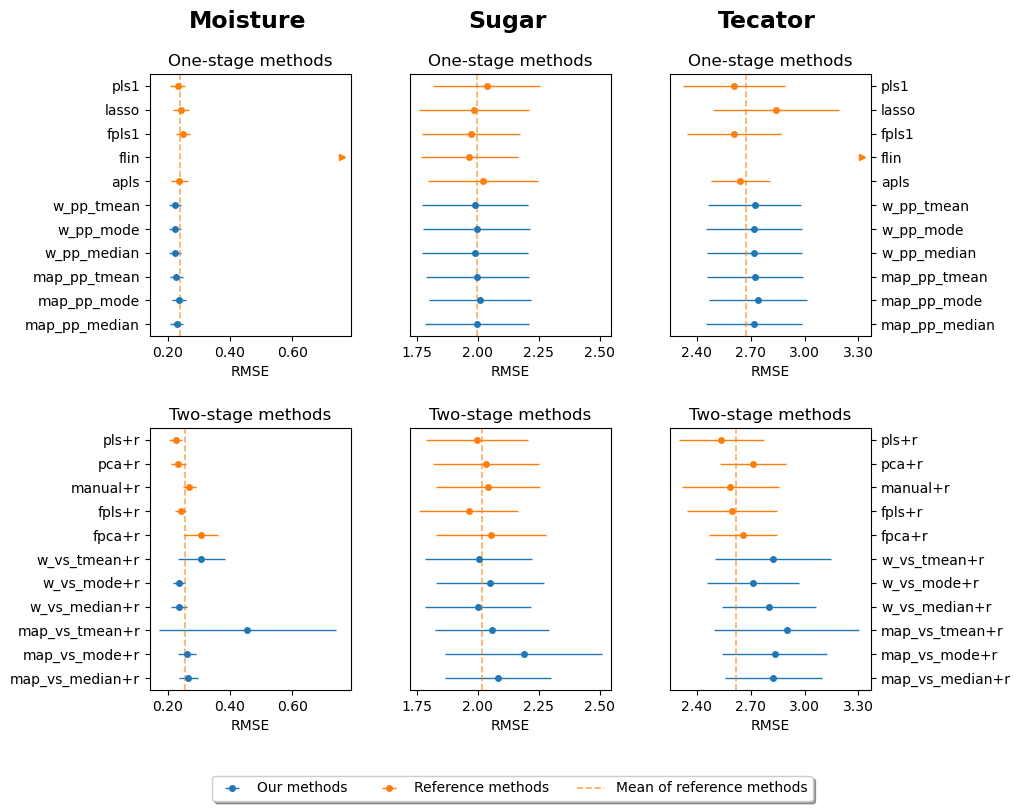

In [305]:
# -- Plot score graphs

if dataname == "rkhs":
    data_all = rkhs
elif dataname == "l2":
    data_all = l2
elif dataname == "non_gp":
    data_all = non_gp
else:
    data_all = real

print(
    "--> "
    + KIND.capitalize()
    + " "
    + dataname.upper()
    + (" (smooth)" if SMOOTHING else "")
    + " <--"
)

plot_data_all(
    data_all,
    dataname,
    limit=limit,
    legend=True,
    figsize=[None, height],  # Default width is 2.5*n_data
    bbox_legend=bbox_legend,
    save=SAVE_FIG,
)